# **CS3630 Project 2**: A Vacuum Cleaning Robot (Spring 2022)

### Dev TAs: Vivek Mallampati, Zhen Jiang
### February 7, 2022


---



# **Introduction**

Welcome to your second project in CS3630 (Spring 2022)!

In this project, we will be building a (simulated) vaccum sorting robot as illustrated in the [Textbook](http://www.roboticsbook.org/intro.html) for this course. 


---


# **Project**


> ***Please select "Copy to Drive" inorder to save the Google Colab to your drive.*** This will save your changes and you can access the assignemnt directly from your google account. 


There are two ways that you can test your implementation:

1. **Running the project:** Running the project involves running the code we will be testing. 
There will be additional tests on Gradescope which are not present in
your local unit tests.

2. **Gradescope Autograder:**You may also submit your code as specified below. 
Gradescope will only reveal the results of the public tests. Your final grade for the coding portion of
this assignment are based on both the public and hidden private tests. We do not recommend using
Gradescope as your primary testing method during development because private test cases will **NOT**
be available to you at any time.
*IMPORTANT NOTE: Please use the variables provided for the results of each of the TODOs.*

---
---

# SUBMISSION GUIDELINES

**Download notebook as submission.py and submit on Gradescope.**

Click "File" on the menu on the left side corner. Select "Download" and select "download .py" to download the notebook as a python file. Please save the file as **"submission.py".**

---

## **Due Date**
**Project 2 is due on Friday, 02/18/2022 11:59PM Easter Time**, with late submission possible until
Monday, 02/21/2022 11:59PM Eastern Time.

### **Deliverables**
Deliverables are submitted on Gradescope. Each student must individually submit assignments. Deliverables are the following files:

*  submission.py: Download the file with the name "submission.py" and submit to Gradescope for “Project 2 - Code”.
*  Project 2 - Report: Reports are administered through GradeScope assignments. The assignment is
not timed, you will have until the deadline to finish the report. Fill out the corresponding regions
with your answers.


# **Grading**
Project 2 is worth 100 points in total. Here is the breakdown of each section’s 
value.

*   Code - 50pts
*   Report - 50pts

## **Collaboration Policy**
All projects in this course this semester are individual projects, which means ***no collaboration is allowed***.
However, you can discuss the projects and the reflection questions at a high level with your classmates or
the TAs. You can also ask questions on Piazza or go to office hours for help. All the code and all the
answers to the reflection questions must be your own.

## **Code Setup**

We will be following the chapters in the book and try to create a vaccum robot which can do tasks over time.

**RERUN THE SETUP CODE EVERYTIME YOU START**
---
DON'T CHANGE THE SETUP CODE! PLEASE START TO WORK FROM SECTION 3.1

---



In [2]:
#Need to run this everytime the notebook gets disconnected
%pip install -q -U gtbook

     |████████████████████████████████| 20.7 MB 18.6 MB/s 


In [3]:
import numpy as np
import gtsam
import pandas as pd
import time
import gtbook
from gtbook.display import show
from gtbook.discrete import Variables
VARIABLES = Variables()
def pretty(obj): 
    return gtbook.display.pretty(obj, VARIABLES)
def show(obj, **kwargs): 
    return gtbook.display.show(obj, VARIABLES, **kwargs)

import plotly.express as px
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"
from enum import Enum

In [4]:
# Constants. DON'T CHANGE THE VARIABLE NAMES AND VALUES
ACTIONS = ["L","R","U","D",]
ROOMS = ["Living Room", "Kitchen", "Office", "Hallway", "Dining Room"]
LIGHT_LEVELS = ["dark", "medium", "light"]

## Section 3.1 State Abstractions

#### REPORT QUESTIONS
###### 1) MCQs to identify Bayesian vs. Frequentist 

*   Finding probability of getting a one after rolling dice 1000 times 
*   Finding probability of getting A in CS 3630 next semester
*   Finding the probability of Rafael Nadal winning the 21 grand slam titles

##### 2) What will be the discrete distribution if the robot ALWAYS starts out in the Living Room?

### *CODING TIME*
In this part we will start by creating action series and state series which will hold the action variables and state variables. Possible actions and states are listed in the constants in the Setup.

[Textbook Section 3.1](https://www.roboticsbook.org/S31_vacuum_state.html) is your best friend.

In [5]:
# TODO 1
def create_action_series(character, indices):
  """
  Returns a discrete series of actions

      Parameters:
          character (str): a single character assigned to the action state variable
          indices (list of ints): a list of integer indices 

      Returns:
          A (dict): a dictionary with the keys being integer indices and the values
                    being gtsam.DiscreteKeys
  """
  A = None
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ###############################################################################
  A = VARIABLES.discrete_series(character, indices, ACTIONS)
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################
  return A



In [6]:
# TODO 2 
def create_state_series(character, indices):
  """
  Returns a discrete series of rooms

      Parameters:
          character (str): a single character assigned to the room state variable
          indices (list of ints): a list of integer indices 

      Returns:
          X (dict): a dictionary with the keys being integer indices and the values
                    being gtsam.DiscreteKeys
  """
  X = None
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ############################################################################### 
  X = VARIABLES.discrete_series(character, indices, ROOMS)
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################
  return X

In [7]:
A = create_action_series("A", [1,2,3,4])
print("Action series:",A)

X = create_state_series("X", [1,2,3,4,5])
print("State series:", X)

Action series: {1: (4683743612465315841, 4), 2: (4683743612465315842, 4), 3: (4683743612465315843, 4), 4: (4683743612465315844, 4)}
State series: {1: (6341068275337658369, 5), 2: (6341068275337658370, 5), 3: (6341068275337658371, 5), 4: (6341068275337658372, 5), 5: (6341068275337658373, 5)}


## Section 3.2 Vacuum Action

#### REPORT QUESTIONS


1.   
Even though the CPT in section 3.2.1 in the [book](https://www.roboticsbook.org/S32_vacuum_actions.html) above has 100 numbers in it, how many independent degrees of freedom do we actually have when specifying this CPT?
2.   If we start from the Dining Room and attempt to go left, i.e., action A0 = L, what is the PMF over the next state?




### *CODING TIME*
In this part we will creating a descrete **Bayes Net** using a simple motion model (conditional probability of the states). 
We will use the actions and states from 3.1 coding part to check our conditional probability model and the Bayes Net created from it.

[Textbook  Section 3.2](https://www.roboticsbook.org/S32_vacuum_actions.html) is your best friend.

In [8]:

# TODO 3
def create_motion_model(actions, states, spec):
  """
  Returns a motion model that describes state transitions P(X2|X1, A1)

      Parameters:
          actions (dict): a discrete series of actions
          states (dict): a discrete series of states (rooms)
          spec (str): a table that contains all possible values for P(X2|X1, A1)

      Returns:
          motion_model (gtsam.DiscreteConditional): a DiscreteConditional that 
          describes the state transition model P(X2|X1, A1)
  """
  motion_model = None
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ############################################################################### 
  motion_model = gtsam.DiscreteConditional(states[2], [states[1], actions[1]], spec)
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################
  return motion_model


Use the probability provided to create a motion model which will be the basis for the bayes net.

In [9]:
prob_spec = """
    1/0/0/0/0 2/8/0/0/0 1/0/0/0/0 2/0/0/8/0
    8/2/0/0/0 0/1/0/0/0 0/1/0/0/0 2/0/0/0/8
    0/0/1/0/0 0/0/2/8/0 0/0/1/0/0 0/0/1/0/0
    0/0/8/2/0 0/0/0/2/8 8/0/0/2/0 0/0/0/1/0
    0/0/0/8/2 0/0/0/0/1 0/8/0/0/2 0/0/0/0/1
    """
  
model = create_motion_model(A,X,prob_spec)
pretty(model)

X1,A1,Living Room,Kitchen,Office,Hallway,Dining Room
Living Room,L,1,0,0,0,0
Living Room,R,0.2,0.8,0,0,0
Living Room,U,1,0,0,0,0
Living Room,D,0.2,0,0,0.8,0
Kitchen,L,0.8,0.2,0,0,0
Kitchen,R,0,1,0,0,0
Kitchen,U,0,1,0,0,0
Kitchen,D,0.2,0,0,0,0.8
Office,L,0,0,1,0,0
Office,R,0,0,0.2,0.8,0


In [10]:

# TODO 4
def create_bayes_net(motion_model):
  """
  Returns a discrete bayes net of the motion model P(X2|X1, A1)

      Parameters:
          motion_model (gtsam.DiscreteConditional): a DiscreteConditional that describes the state transition model P(X2|X1, A1)

      Returns:
          bayes_net (gtsam.DiscreteBayesNet): a DiscreteBayesnet that describes the motion model
  """
  bayes_net = None
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ############################################################################### 
  bayes_net = gtsam.DiscreteBayesNet()
  bayes_net.add(motion_model)
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################
  return bayes_net

You can test the bayes net function by checking if this creates a 3 node graph with X1 and A1 pointing to X2. 

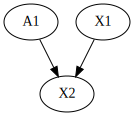

In [114]:
bayes_net = create_bayes_net(model)
show(bayes_net)

## Section 3.3 Vacuum Sensing


#### REPORT QUESTIONS


1.   Please run the ancestral sampling 100 times using the prior given by the TAs. Plot the histogram of the starting state X1.
2.   We see that we are sometimes starting in the living room when we are running the ancestral sampling algorithm. 
What would you change to always start in the office? 




### *CODING TIME*

Let us start with a quick warm-up excercise of create a descrete series for sensor. The possible values of sensors in the coonstant. 

In this part we will be creating **Dynamic Bayes Net** and running **Ancestral sampling algorithm** on the DBN.
We will use the bayes net from 3.2 coding part to start our implementation here.

There are few helper functions which will ask you to create different priors and action sequences. These will be useful deepining your understanding and also testing your code.

[Textbook  Section 3.3](https://www.roboticsbook.org/S33_vacuum_sensing.html) is your best friend.

In [115]:
# TODO 5
def create_sensor_series(character, indices):
  """
  Returns a discrete series of light levels

      Parameters:
          character (str): a single character assigned to the light levels state variable
          indices (list of ints): a list of integer indices 

      Returns:
          Z (dict): a dictionary with the keys being integer indices and the values
                    being gtsam.DiscreteKeys
  """
  Z = None
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ############################################################################### 
  Z = VARIABLES.discrete_series(character, indices, LIGHT_LEVELS)
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################
  return Z

In [12]:
Z = create_state_series("Z", [1,2,3,4,5])
print("Measurement series:", Z)

Measurement series: {1: (6485183463413514241, 5), 2: (6485183463413514242, 5), 3: (6485183463413514243, 5), 4: (6485183463413514244, 5), 5: (6485183463413514245, 5)}


In [13]:
def get_prior():
  """
  Returns the priors to have uniform distribution amongst all the rooms.

  """
  return "1/1/1/1/1"

#TODO 6
def get_office_start_prior():
  """
  Change office_start_prior such that it reflects the knowledge that the robot always starts at the office

  """
  office_start_prior = ""
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ############################################################################### 
  office_start_prior = "0/0/1/0/0"
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################
  return office_start_prior

In [14]:
#TODO 7
def create_dbn(bayes_net, priors, X, A, Z, sensor_spec, action_spec, N):
  """
  Return a dynamic bayes net

      Parameters:
          bayes_net (gtsam.DiscreteBayesNet): a discrete bayes net that describes the motion model
          priors (str): the prior knowledge of the robot regards the room state
          X (dict): a discrete series of (room) states
          A (dict): a discrete series of actions
          Z (dict): a discrete series of sensor measurements (light levels)
          sensor_spec (str): A table that contains all possible values of P(Z1|X1)
          action_spec (str): A table that contains all possible values of P(X2|X1, A1)
          N: number of states for the DBN

      Returns:
          dbn (gtsam.DiscreteBayesNet): the dynamic bayes net that represents the evolution of the (room) state over time
  """
  dbn = None 
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ############################################################################### 
  dbn = bayes_net
  for k in range(1,N+1):
    dbn.add(Z[k], [X[k]], sensor_spec)
  for k in reversed(range(1, N)):
    dbn.add(X[k+1], [X[k], A[k]], action_spec)
  dbn.add(X[1], "1/1/1/1/1")
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################
  return dbn


In [15]:
priors = get_prior()
action_spec = """
    1/0/0/0/0 0/1/0/0/0 1/0/0/0/0 0/0/0/1/0
    1/0/0/0/0 0/1/0/0/0 0/1/0/0/0 0/0/0/0/1
    0/0/1/0/0 0/0/0/1/0 0/0/1/0/0 0/0/1/0/0
    0/0/1/0/0 0/0/0/0/1 1/0/0/0/0 0/0/0/1/0
    0/0/0/1/0 0/0/0/0/1 0/1/0/0/0 0/0/0/0/1
    """
sensor_spec = "1/1/8 1/1/8 2/7/1 8/1/1 1/8/1"
N = 5
X = create_state_series("X", range(1,N+1))
A = create_action_series("A", range(1,N))
Z = create_sensor_series("Z", range(1,N+1))

You can visualize the Dynamic Bayes Net which you have created. Try to think how will it look before actually running it. 

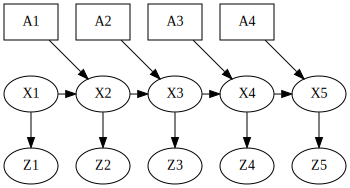

In [16]:
bayes_net = gtsam.DiscreteBayesNet()
dbn = create_dbn(bayes_net,priors, X, A, Z, sensor_spec, action_spec, 5)
show(dbn, hints={"A":2, "X":1, "Z":0}, boxes={A[k][0] for k in range(1,N)})
# pretty(dbn)

In [17]:
#TODO 8
def create_all_left_action_sequence(A,num_actions):
  """
  Return an action sequence such that all actions within the sequence is "L" (left)

      Parameters:
          A: Actions dictionary
          num_actions (int): number of actions within the sequence

      Returns:
          action_seq (dict): a dictionary with the key being the action state variable (for instance, "A1", "A2", ...)
                             and the value being the left action "L"
  """
  action_seq  = None
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ############################################################################### 
  action_seq = {A[k]: "L" for k in range(1, num_actions + 1)}
  #action_seq = {A[k]: "R" for k in range(1,5)} 
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################
  return action_seq

#TODO 9
def create_custom_action_sequence(A, num_actions):
  """
  Return an action sequence such that all actions within the sequence is "L" (left) except the last action being "U" (up)
  For example, if num_action is 1, then action sequence is {"A1": "U"}
               if num_action is 2, then action sequence is {"A1": "L", "A2": "U"}
               if num_action is 3, then action sequence is {"A1": "L", "A2": "L", "A3": "U"}

      Parameters:
          A: Actions dictionary
          num_actions (int): number of actions within the sequence

      Returns:
          action_seq (dict): a dictionary with the key being the action state variable (for instance, "A1", "A2", ...)
                             and the value being the specific action from "L", "R", "U", "D"
  """
  action_seq  = None
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ############################################################################### 
  action_seq = {A[k]: "L" for k in range(1, num_actions+1)}#,{A[1]: "U"}
  #action_seq = {action_seq, A[num_actions+1]: "U"}
  action_seq[A[num_actions]] = "U"
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################
  return action_seq


In [18]:
#TODO 10
def ancestral_sampling(dbn, action_sequence):
  """
  Returns an ancestral sampling of a dynamic bayes net

      Parameters:
          dbn (gtsam.DiscreteBayesNet): the dynamic bayes net that represents the evolution of the (room) state over time
          action_sequence (dict): a dictionary with the key being the action state variable (for instance, "A1", "A2", ...)
                                  and the value being the specific action from "L", "R", "U", "D"

      Returns:
          samples (gtsam.DiscreteValues): a DiscreteValues variable that contains key-value pairs with the key being all variables
                                          within the dynamic bayes net (for instance X1, X2, A1, A2, Z1, Z2) and the value being
                                          its corresponding sampled value
  """
  samples = None 
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ############################################################################### 
  #actions_list = gtsam.DiscreteValues()
  A = create_action_series("A", range(1,len(action_sequence)+1))
  
  #action_sequence_items = action_sequence.items()
  actionsS = []
  for key in action_sequence:
    actionsS.append(action_sequence[key])
  #print(actionsS)
  #actionsS = VARIABLES.assignment({A[k]: ACTIONS(actions[k]) for k in range(0,len(action_sequence))})
  #actionsS = []
  #for k in range(0, 0):
  #  actionsS.append(VARIABLES.assignment({A[k]: ACTIONS(actions[k])}))
  actions = VARIABLES.assignment({A[k]: actionsS[k-1] for k in range(1,len(action_sequence)+1)})
  #print(actions)
  samples = dbn.sample(actions)
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################
  return samples

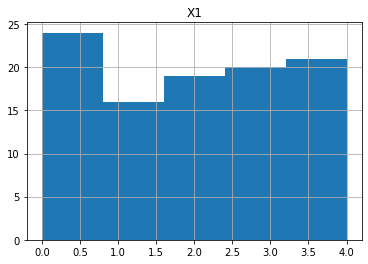

In [113]:
priors = get_prior()
action_spec = """
    1/0/0/0/0 0/1/0/0/0 1/0/0/0/0 0/0/0/1/0
    1/0/0/0/0 0/1/0/0/0 0/1/0/0/0 0/0/0/0/1
    0/0/1/0/0 0/0/0/1/0 0/0/1/0/0 0/0/1/0/0
    0/0/1/0/0 0/0/0/0/1 1/0/0/0/0 0/0/0/1/0
    0/0/0/1/0 0/0/0/0/1 0/1/0/0/0 0/0/0/0/1
    """
sensor_spec = "1/1/8 1/1/8 2/7/1 8/1/1 1/8/1"
N = 5
X = create_state_series("X", range(1,N+1))
A = create_action_series("A", range(1,N))
Z = create_sensor_series("Z", range(1,N+1))
bayes_net = gtsam.DiscreteBayesNet()
dbn = create_dbn(bayes_net,priors, X, A, Z, sensor_spec, action_spec, 5)
starting_states = []
for i in range(100):
  sample = ancestral_sampling(dbn, {A[k]: "R" for k in range(1,5)})
  iter = sample.items()
  x1 = next(iter)
  x1 = next(iter)
  x1 = next(iter)
  x1 = next(iter)
  x1 = next(iter)
  starting_states.append(x1[1])
df = pd.DataFrame({'X1': starting_states})
#print(starting_states)
hist = df.hist(bins = 5)
  #starting_states.append(sample.key("X1"))


In [33]:
#Change "test_action_sequence" using the two functions above 
# i.e,  create_custom_action_sequnece and create_all_left_action_sequnece

test_action_sequence = {A[k]: "R" for k in range(1,5)} 
#test_action_sequence = create_all_left_action_sequence(A,2)
#test_action_sequence = create_custom_action_sequence(A,4)

pretty(ancestral_sampling(dbn, test_action_sequence))

Variable,value
A1,R
A2,R
A3,R
A4,R
X1,Kitchen
X2,Kitchen
X3,Kitchen
X4,Kitchen
X5,Kitchen
Z1,light


## Section 3.4 Vacuum Perception

#### REPORT QUESTIONS



1.   Calculate the size of the table needed to enumerate the posterior over the states S the robot dynamic Bayes net from the previous section, given the value of all observations O and actions A.
2.   Given the DBN from the textbook,

*   If the actions and the measurements are known, how does the factor graph look like?
*   If the actions and the measurements are unknown, how does the factor graph look like?
*   If the actions and the measurements are unknown, but the trajectory of the states is known, how does the factor graph look like? Do you observe any direct findings from the factor graph?

3.  Please plot the graph from the coding section (3.4) which compares the time complexity of Naïve MPE implementations vs GTSAM implementation 
4.  What is the time complexity of MPE when enumerating over an N different number of states? 
Choose from the option

  ● Linear(ax+c)      ● Cubic(ax3+c)     ● Quintic(ax5+c)   ● Exponential(ex+c) 







### *CODING TIME*

This part has two components, understanding the code and implementing the code.

In this part we will be implementing **MPE**.
We will use the DBN from 3.3 coding part to start our implementation here.

[Textbook  Section 3.4](https://www.roboticsbook.org/S34_vacuum_perception.html) is your best friend.

In [116]:
def create_factor_graph(N):
  priors = get_prior()
  X = create_state_series("X", range(1,N+1))
  A = create_action_series("A", range(1,N))
  Z = create_sensor_series("Z", range(1,N+1))
  action_assignment = VARIABLES.assignment(create_custom_action_sequence(A, N-1))

  graph = gtsam.DiscreteFactorGraph()
  graph.add(X[1], "1 1 1 1 1") # \phi(X_1) = P(X_1)
  for k in range(1,N):
      conditional = gtsam.DiscreteConditional(X[k+1], [X[k], A[k]], action_spec)
      conditional_a_k = conditional.choose(action_assignment) # \phi(X,X+) = P(X+|X,A=a)
      graph.push_back(conditional_a_k)
  for k, measurement in enumerate(LIGHT_LEVELS):
      conditional = gtsam.DiscreteConditional(Z[k+1], [X[k+1]], sensor_spec)
      z_k = LIGHT_LEVELS.index(measurement)
      factor = conditional.likelihood(z_k) # \phi(X) = P(Z=z|X)
      graph.push_back(factor)
  return graph,X

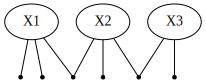

In [117]:
graph,X1 = create_factor_graph(3)
show(graph)

In [118]:
def generateAllTrajactories(n, X, arr, i,trajectories_list):
    if i == n:
        trajectories_list.append(VARIABLES.assignment({X[k+1]:arr[k] for k in range(n)}))
        return

    for elem in range(5):
      arr[i] = ROOMS[elem]
      generateAllTrajactories(n, X, arr, i + 1,trajectories_list)


#TODO 11
def naive_MPE(graph, N, X):
  """
  Implement the function to return the value for maximum probable explanation and its corresponding state trajectory

    Parameters:
        graph (gtsam.DiscreteFactorGraph): the factor graph used to find mpe
        N: number of states
        X: states dictionary

    Returns:
        mpe_value (float): the value for maximum probable explanation
        mpe_trajectory (gtsam.DiscreteValues): the DiscreteValues variable that contains the key-value pair with the key being the
                                                (room) state variable and the value being its corresponding value
  """
  mpe_value = 0
  mpe_trajectory = None
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ###############################################################################
  trajectory_list = []
  arr = []
  for i in range(N):
    arr.append(0)
  generateAllTrajactories(N, X, arr, 0, trajectory_list) 
  for trajectory in trajectory_list:
    value = graph(trajectory)
    if value > mpe_value:
      mpe_value = value
      mpe_trajectory = trajectory
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################    
  return mpe_value, mpe_trajectory

In [119]:
N = 3
cur_graph,cur_X = create_factor_graph(N)
mpe_value,mpe_trajectory = naive_MPE(cur_graph,N,cur_X)
print(mpe_value)
pretty(mpe_trajectory)

0.055999999999999994


Variable,value
X1,Hallway
X2,Office
X3,Office


In [120]:
#TODO 12
def GTSAM_MPE(graph):
  """
  Implement the function to return the mpe trajectory using gtsam

      Parameters:
          graph (gtsam.DiscreteFactorGraph): the factor graph used to find mpe

      Returns:
          mpe_trajectory (gtsam.DiscreteValues): the DiscreteValues variable that contains the key-value pair with the key being the
                                                 (room) state variable and the value being its corresponding value
  """
  mpe = None
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ############################################################################### 
  mpe = graph.optimize()
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################
  return mpe

In [121]:
N = 3
cur_graph,_ = create_factor_graph(N)
mpe_trajectory = GTSAM_MPE(cur_graph)
print(mpe_trajectory)

DiscreteValues{6341068275337658369: 3, 6341068275337658370: 2, 6341068275337658371: 2}


Try to modify the Naive MPE and GTSAM MPE code to run for different values of N and get execution time.
This is an opportunity to explore packages outside of what we have provided. Feel free to import external packages like [time](https://docs.python.org/3/library/time.html#time.time) which makes it easy to get the execution time. 

To plot the graph, use values of N from 3 to 9

In [122]:
#TODO 13
def plot_time_complexity():
  """
  Plot the graph to compare the execution time between the naive mpe approach and the gtsam approach
  Check out https://plotly.com/python/plotly-express/ for more info about using plotly.

  X-axis should the N (number states) and Y-axis should be execution time
  """
  figure = None
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ###############################################################################
  
  time_naive = []
  time_gtsam =[]
  times = []
  for i in range(3, 10):
    graph,X1 = create_factor_graph(i)
    start = time.perf_counter()
    naive_MPE(graph, i, X1)
    end = time.perf_counter() 
    time_naive.append(end-start)
    times.append(end-start)
  # intialise data of lists.
  data_naive = {'States':[3, 4, 5, 6, 7, 8, 9],
        'TimeNaive': time_naive}
 
  # Create DataFrame
  df = pd.DataFrame(data_naive)
  for i in range(3, 10):
    graph,X1 = create_factor_graph(i)
    start = time.perf_counter()
    GTSAM_MPE(graph)
    end = time.perf_counter()
    time_gtsam.append(end-start)
    times.append(end-start)
  # intialise data of lists.
  data_gtsam = {'States':[3, 4, 5, 6, 7, 8, 9],
        'TimeGT': time_gtsam}
 
  # Create DataFrame
  df2 = pd.DataFrame(data_gtsam)
  data = {'States':[3, 4, 5, 6, 7, 8, 9],
        'TimeNaive': time_naive, 'TimeGT': time_gtsam}
  #data.assign
  figure = px.scatter(data, x = "States", y = ["TimeNaive", "TimeGT"]) #This function might be useful
  #data = {'key': {0: 'Naive', 1: 'GT'}, 'States':[3, 4, 5], 'Time': time_naive, 'Time': time_gtsam}
  #figure = px.scatter(data, x = "States", y = "Time", color = "key")
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################
  return figure



In [123]:
fig = plot_time_complexity()
fig.show()

## Section 3.5 Vacuum Decision

#### REPORT QUESTIONS



1.  What is roll-out reward?
2.   Compare two control tapes provided in the code. What is the optimal control tapes? Why?
3. Based on the code(Policy Iteration function) you ran, what is the optimal policy?

4. What's the objective of using policy iteration? What's the objective of using value iteration?


### *CODING TIME*

In this part we will be implementing **Policy Iteration**.

We will be working on creating a markov chain and run different methods of evaluating the series of actions. We will implement a method to find reward given a fixed control tape as well as a policy. Finally we will run Policy Iteration algorithm to find the optimal policy. 

[Textbook Section 3.5](https://www.roboticsbook.org/S35_vacuum_decision.html) is your best friend.

In [124]:
#TODO 14

def create_markovChain(action_spec, N):
  """
  Implement the function such that it returns a Markov Chain 

      Parameters:
          N (int): number of states

      Returns:
          markovChain (gtsam.DiscreteBayesNet): a DiscreteBayeesNet that describes the Markov Chain 
  """
  X = VARIABLES.discrete_series("X", range(1, N+1), ROOMS)
  A = VARIABLES.discrete_series("A", range(1, N), ACTIONS)
  markovChain = gtsam.DiscreteBayesNet()
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ############################################################################### 
  for k in reversed(range(1,N)):
    markovChain.add(X[k+1], [X[k], A[k]], action_spec)
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################
  return markovChain

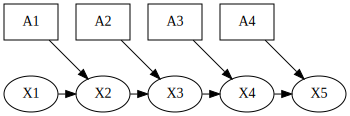

In [126]:
N = 5
action_spec = """
      1/0/0/0/0 2/8/0/0/0 1/0/0/0/0 2/0/0/8/0
      8/2/0/0/0 0/1/0/0/0 0/1/0/0/0 2/0/0/0/8
      0/0/1/0/0 0/0/2/8/0 0/0/1/0/0 0/0/1/0/0
      0/0/8/2/0 0/0/0/2/8 8/0/0/2/0 0/0/0/1/0
      0/0/0/8/2 0/0/0/0/1 0/8/0/0/2 0/0/0/0/1
      """
markovChain = create_markovChain(action_spec, N)
show(markovChain, hints={"A":2, "X":1, "Z":0}, boxes={A[k][0] for k in range(1,N)})


In [125]:
def reward_function(state:str, action:str, next_state:str):
    """
    Reward that returns 10 upon entering the living room.
    """
    return 10.0 if next_state == "Living Room" else 0.0

def perform_rollout(markovChain, x1, actions):
    """Roll out states given actions as a dictionary"""
    dict = actions.copy()
    dict[X[1]] = x1
    given = VARIABLES.assignment(dict)
    return markovChain.sample(given)
  
def reward(R, rollout, A, X, k):
    """Return state, action, next_state triple for given rollout at time k."""
    state = rollout[X[k][0]]
    action = rollout[A[k][0]]
    next_state = rollout[X[k+1][0]]
    return R[state, action, next_state]

def rollout_reward(R, rollout, A, X, horizon=N, gamma=1.0):
    """Calculate reward for a given rollout"""
    discounted_rewards = [gamma**(k-1) * reward(R, rollout, A, X, k) for k in range(1,horizon)]
    return sum(discounted_rewards)

def get_transition_prob(action_spec):
  conditional = gtsam.DiscreteConditional((2,5), [(0,5), (1,4)], action_spec)
  T = np.empty((5, 4, 5), float)
  for assignment, value in conditional.enumerate():
      x, a, y = assignment[0], assignment[1], assignment[2]
      T[x, a, y] = value
  return T

In [127]:
#TODO 15
def get_expected_reward(action_spec):
  """
    Implement the function to calculate the reward given a sequence of actions
    Parameters:
            action_spec (str): A table that contains all possible values of P(X2|X1, A1)

    HINT: What does the variable assignment store? How should the reward function be used?
  """
  conditional = gtsam.DiscreteConditional((2,5), [(0,5), (1,4)], action_spec)
  R = np.empty((5, 4, 5), float)
  for assignment, value in conditional.enumerate():
      ###############################################################################
      #                             START OF YOUR CODE                              #
      ############################################################################### 
      x, a, y = assignment[0], assignment[1], assignment[2]
      R[x, a, y] = reward_function(x, a, ROOMS[y])
      ###############################################################################
      #                              END OF YOUR CODE                               #
      ###############################################################################
  return R

#TODO 16
def control_tape_reward(markovChain, x1, actions, R, A, X):
    """
      Implement the function to calculate the reward given a sequence of actions
      Parameters:
          x1 (str): the initial (room) state 
          actions (dict): the dictionary that represents a sequence of actions taken by the agent
          R: array of expected reward given the current state, 
    """
    ###############################################################################
    #                             START OF YOUR CODE                              #
    ############################################################################### 
    rollout = perform_rollout(markovChain, x1, actions)
    reward = rollout_reward(R, rollout, A, X)
    ###############################################################################
    #                              END OF YOUR CODE                               #
    ###############################################################################
   
    return reward

In [145]:
R = get_expected_reward(action_spec)
actions_1 = {A[1]:"R", A[2]:"U", A[3]:"R", A[4]:"U"}
actions_2 = {A[1]:"R", A[2]:"U", A[3]:"U", A[4]:"U"}
N = 6
X = create_state_series("X", range(1,N+1))
A = create_action_series("A", range(1,N))
Z = create_sensor_series("Z", range(1,N+1))
actions_3 = {A[1]:"R", A[2]:"U", A[3]:"R", A[4]:"D", A[5]: "L"}

print([control_tape_reward(markovChain, "Office", actions_1,R,A,X) for i in range(10)])
print([control_tape_reward(markovChain, "Office", actions_2,R,A,X) for i in range(10)])
print([control_tape_reward(markovChain, "Office", actions_3,R,A,X) for i in range(10)])

[10.0, 10.0, 0.0, 10.0, 10.0, 0.0, 10.0, 10.0, 10.0, 10.0]
[10.0, 0.0, 10.0, 10.0, 10.0, 10.0, 10.0, 0.0, 0.0, 0.0]
[10.0, 10.0, 0.0, 10.0, 10.0, 10.0, 10.0, 10.0, 0.0, 10.0]


We looked into to control tapes, but the fixed control tape can never garuantee optimality because it can't be updated on the go. Now let us look into policies.

In [134]:
#TODO 17
def get_custom_policy(N):
  """
      Implement the function to create a customized policy

      Parameters:
          N (int): number of actions within the policy

      Returns:
          policy (list): a list of actions (refer to the implementation of the get_test_policy function below)
  """
  policy = None
  ###############################################################################
  #                             START OF YOUR CODE                              #
  ############################################################################### 
  policy = []
  for i in range (N):
    i = (i + 2) % 4
    policy.append(i)
  ###############################################################################
  #                              END OF YOUR CODE                               #
  ###############################################################################
  return policy

def get_test_policy(N):
  RIGHT_INDEX = ACTIONS.index("R")
  LEFT_INDEX = ACTIONS.index("L")
  UP_INDEX = ACTIONS.index("U")
  DOWN_INDEX = ACTIONS.index("D")

  reasonable_policy = [UP_INDEX, LEFT_INDEX, RIGHT_INDEX, UP_INDEX, LEFT_INDEX]
  return reasonable_policy

def Q_value(R, T, value_function, x, a, gamma=0.9):
    """Calculate Q(x,a) from given value function"""
    return T[x,a] @ (R[x,a] + gamma * value_function)
    
def calculate_value_system(pi, R, T, gamma=0.9):
    """Calculate A, b matrix of linear system for value computation."""
    b = np.empty((5,), float)
    AA = np.empty((5,5), float)
    for x, room in enumerate(ROOMS):
        a = pi[x] # action under policy
        b[x] = T[x,a] @ R[x,a] # expected reward under policy pi
        AA[x] = -gamma * T[x,a]
        AA[x,x] += 1
    return AA,b
    
def calculate_value_function(pi, R,T, gamma=0.9):
    """Calculate value function for given policy"""
    AA, b = calculate_value_system(pi, R,T, gamma)
    return np.linalg.solve(AA,b)

In [135]:
test_policy = get_custom_policy(5) #replace with your policy using get_custom_policy()
T = get_transition_prob(action_spec)
value_for_pi = calculate_value_function(test_policy, R,T,)
print("V(always_right):")
for i,room in enumerate(ROOMS):
    print(f"  {room:12}: {value_for_pi[i]}")

V(always_right):
  Living Room : 100.00000000000007
  Kitchen     : 54.37665782493375
  Office      : 0.0
  Hallway     : 41.922753445041145
  Dining Room : 47.74535809018574


Now you should try to find the OPTIMAL Policy

In [136]:
def update_policy(R,T,value_function):
    """Update policy given a value function"""
    new_policy = [None for _ in range(5)]
    for x, room in enumerate(ROOMS):
        Q_values = [Q_value(R, T,value_function, x, a) for a in range(4)]
        new_policy[x] = np.argmax(Q_values)
    return new_policy

#TODO 18
def policy_iteration(R,T,pi=None, max_iterations=100):
    """
        Create the function to implement policy iteration

        Parameters:
            R: the reward function
            T: the transition probabilities
            pi: the policy to start with
            max_iterations: number of iterations for policy iteration

        Returns:
            optimal_policy: the optimal policy after running the policy iteration
            optimal_value_function: the corresponding value function of the optimal policy

        (Refer to the chapter 3.5 of the robotics book)
    """
    for _ in range(max_iterations):
      ###############################################################################
      #                             START OF YOUR CODE                              #
      ############################################################################### 
      value_for_pi = calculate_value_function(pi, R, T) if pi is not None else np.zeros((5,))
      new_policy = update_policy(R, T, value_for_pi)
      if new_policy == pi:
          return pi, value_for_pi
      pi = new_policy
      ###############################################################################
      #                              END OF YOUR CODE                               #
      ###############################################################################
    raise RuntimeError("No stable policy found after {max_iterations} iterations")   


Run the cell below to find out the optimal actions and the resultant optimal values.

In [146]:
policy = get_custom_policy(5) #replace with your policy using get_custom_policy()
optimal_policy, optimal_value_function = policy_iteration(R,T,policy)
print([ACTIONS[a] for a in optimal_policy])
print("The optimal values at each state when the optimal policy followed:")
for i,room in enumerate(ROOMS):
    print(f"  {room:12}: {optimal_value_function[i]}")

['L', 'L', 'R', 'U', 'U']
The optimal values at each state when the optimal policy followed:
  Living Room : 100.00000000000001
  Kitchen     : 97.56097560975611
  Office      : 85.66329565734684
  Hallway     : 97.5609756097561
  Dining Room : 85.66329565734685




---



# YOU ARE DONE! 🥳🥳🥳🥳

Download notebook as **submission.py** and submit on Gradescope.





---

